<a href="https://colab.research.google.com/github/sunRise9551/Building_Micrograd_from_Scratch/blob/main/Building_Micrograd_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Understand Concept of Derivative

Let's say we have a function f(x)

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

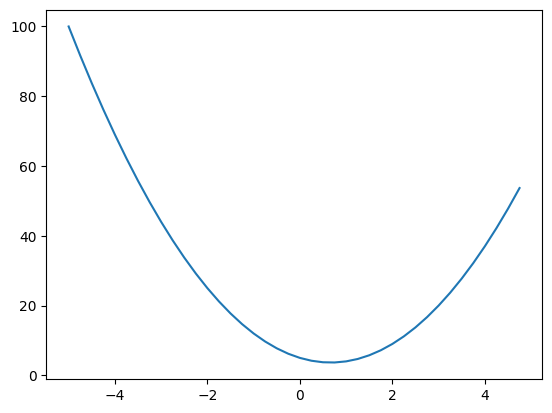

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

# Calculate Simple Derivative

Let's say we want to calculate the derivative of:
x with respect to f()

In [ ]:
h = 0.000001 # represents a small increment for calculating the derivative
x = 2/3 # the point of the above graph when x=2/3
(f(x + h) - f(x)) / h # the slope of that point, which approximates the derivative

2.999378523327323e-06

More complex function

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


We now have a function f(a*b + c)

We want to calculate the derivative of:

'a' with respect to 'f'

'b' with respect to 'f'

'c' with respect to 'f'

So, We will bump tiny amount of h to 'a' 'b' 'c' each time and calculate their derivative

### Derivative for 'a'

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # computes the result before 'a' being increment
a += h # increment 'a' by h amount
d2 = a*b + c # computes the result after 'a' being increment

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # this is the derivative for 'a'

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


## Derivative for 'b'

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # computes the result before 'b' being increment
b += h # increment 'c' by h amount
d2 = a*b + c # computes the result after 'b' being increment

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # this is the derivative for 'b'

d1 4.0
d2 4.0002
slope 2.0000000000042206


## Derivative for 'c'

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # computes the result before 'c' being increment
c += h # increment 'c' by h amount
d2 = a*b + c # computes the result after 'c' being increment

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # this is the derivative for 'c'

d1 4.0
d2 4.0001
slope 0.9999999999976694


# Create Value Object

We have now understand how derivative works, we can then start working on creating Value object for micrograd

## Operation Sum and Mul

Create a Value Object that can perform + and * operation

In [ ]:
class Value:

  def __init__(self, data):
    self.data = data # store data

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data) # Take in self.data + other.data
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data) # Take in self.data * other.data
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

print(a*b)
print(a.__mul__(b)) # equivalent to this

print(a*b + c)
print((a.__mul__(b)).__add__(c)) # equivalent to this


Value(data=-6.0)
Value(data=-6.0)
Value(data=4.0)
Value(data=4.0)


## Store Childs node

Create a variable to store its childs

This is the concept:
1. We will create a new variable 'a _children=()' tuple to store its parents
2. When we are creating a Value, it will not store anything to the tuple
3. When we are doing Addition or Multiplication, we will assign its parent to the tuple


In [ ]:
class Value:

  def __init__(self, data, _children=()):
    self.data = data # store data
    self._prev = set(_children)

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,
                (self, other) # Pass itself and other to the tuple
                )
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,
                (self, other) # Pass itself and other to the tuple
                )
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c

print(d._prev)

# We can now see that the childrens for 'd' are (a*b) and (c)
# (a*b) and (c)
# (2.0*-3.0) and (10.0)
# (-6.0) and (10.0)

{Value(data=-6.0), Value(data=10.0)}


## Store Operations

Create a variable _op=' ' to store its operations

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op=''):
    self.data = data # store data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,
                (self, other),
                _op='+'
                )
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,
                (self, other),
                _op='*'
                )
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c

print(d._op)
# We can now know that the 'd' variable is compute by sum '+'

+


# Visualize Structure

Visualize What we have done so far

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it

    # -------------------------- No Label and Grad for Now --------------------------------------
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ data %.4f }" % (n.data), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

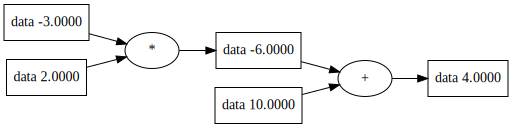

In [ ]:
draw_dot(d)

## Create Label for Graph

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data # store data
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,
                (self, other),
                _op='+'
                )
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,
                (self, other),
                _op='*'
                )
    return out

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

Visualize Label

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it

    # -------------------------- No Grad for Now --------------------------------------
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

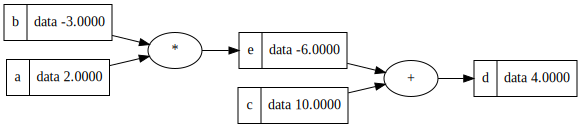

In [ ]:
draw_dot(d)

Let's make another variable L to be the last output

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

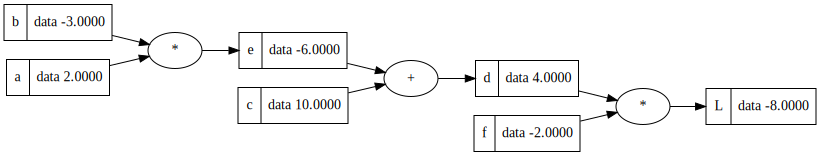

In [ ]:
draw_dot(L)

## Create Gradient for Graph

The concept:

We will now need to put in grad into our current Value object structure.

Grad will calculate the derivative

Grad will initially be 0, because we need to assume that every single value will not affect the Output

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0 # gradient will initially be 0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,
                (self, other),
                _op='+'
                )
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,
                (self, other),
                _op='*'
                )
    return out

Update our Visualize code, include grad

In [21]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it

    # -------------------------- Include Grad, Label, Data --------------------------------------
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

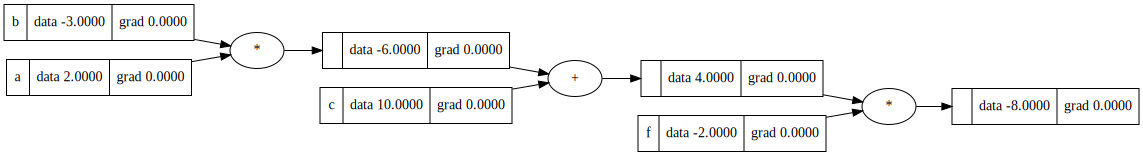

In [ ]:
draw_dot(L)

Backpropagation (Simple Expression)

Calculate Derivative of L with respect to L

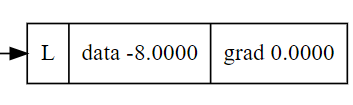

In [ ]:
# We create this function is just to not mess up the Global variables.
def lol():

  h = 0.0001

  # Without Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # With Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h # we increment h to L

  print((L2 - L1) / h)

lol()

0.9999999999976694


# Backpropagation (Simple Expression)

## Calculate dL/dd

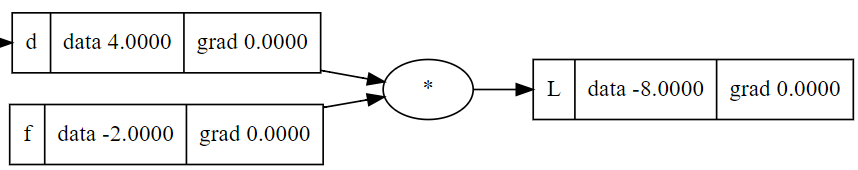

In [ ]:
# We now know that:
# L = d * f

# If we want to calculate the derivative will be:
# dL/dd = ?

# We apply the calculus properties thingi:
# = (f(x + h) - f(x)) / h
# = ((d + h)*f - d * f) / h
# = (d*f + h*f - d * f) / h
# = (h*f) / h
# = f

# dL/dd = -2.0
# So, gradient for d is -2.0
# because f is equal to -2.0

In [ ]:
d.grad = -2.0

Let's Verify

In [ ]:
# We create this function is just to not mess up the Global variables.
def lol():

  h = 0.0001

  # Without Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # With Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h # we increment h to d
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.9999999999953388


## Calculate dL/df

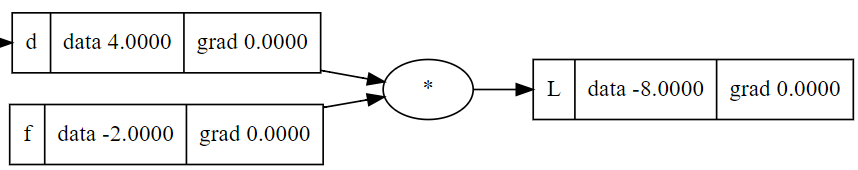

In [ ]:
# We now know that:
# L = d * f

# If we want to calculate the derivative will be:
# dL/df = ?

# We apply the calculus properties thingi:
# = (f(x + h) - f(x)) / h
# = (d*(f + h) - d * f) / h
# = (d*f + d*h - d * f) / h
# = (d*h) / h
# = d

# dL/df = 4.0
# So, gradient for f is 4.0
# because d is equal to 4.0

In [ ]:
f.grad = 4.0

Let's Verify

In [ ]:
# We create this function is just to not mess up the Global variables.
def lol():

  h = 0.0001

  # Without Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # With Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0 + h, label='f')  # we increment h to f
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

3.9999999999995595


## Calculate dL/de

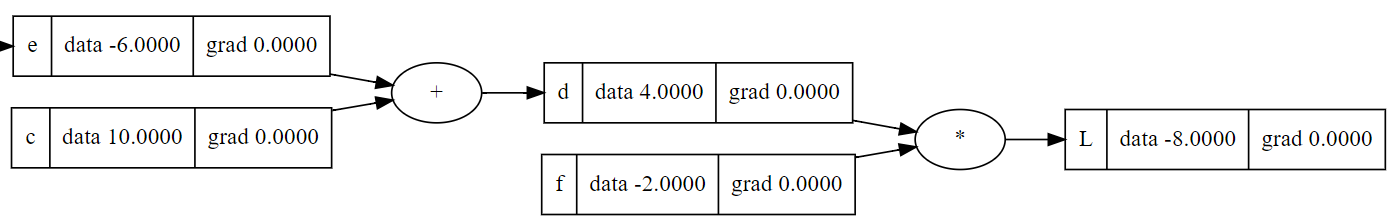

In [ ]:
# (Chain Rule)

# We know that:
# L = d * f
# d = e + c (Local)

# (Local Derivative)
# If we want to calculate the derivative will be:
# dd/de = ?

# We apply the calculus properties thingi:
# = (f(x + h) - f(x)) / h
# = ((e+h + c) - (e + c)) / h
# = (e + h + c - e - c) / h
# = h / h
# = 1.0

# dd/de = 1.0
# This is the derivative for dd/de, but we are not done yet!

In [ ]:
# Now

# Want:
# dL/de

# Know:
# dd/de and dL/dd

# So, we can apply the chain rule
# dL/de = (dL/dd)*(dd/de)
# dL/de = (-2.0)*(1.0)
# dL/de = -2.0

# So, gradient for e is -2.0

In [ ]:
e.grad = -2.0

Let's Verify

In [ ]:
# We create this function is just to not mess up the Global variables.
def lol():

  h = 0.0001

  # Without Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # With Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  e.data += h # we increment h to e
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.9999999999953388


## Calculate dL/dc

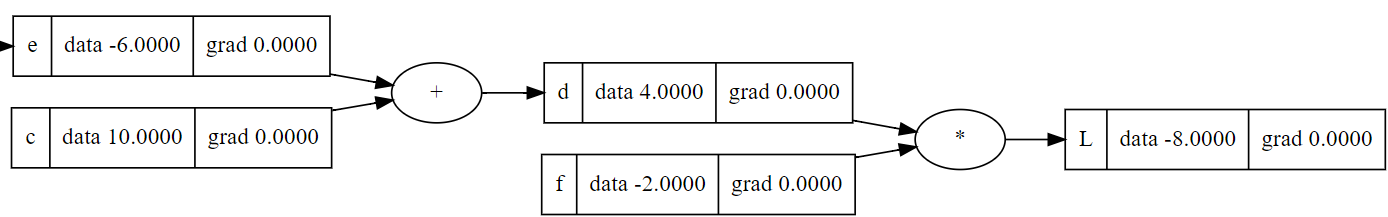

In [ ]:
# (Chain Rule)

# We know that:
# L = d * f
# d = e + c (Local)

# (Local Derivative)
# If we want to calculate the derivative will be:
# dd/dc = ?

# We apply the calculus properties thingi:
# = (f(x + h) - f(x)) / h
# = ((e + c+h) - (e + c)) / h
# = (e + c + h - e - c) / h
# = h / h
# = 1.0

# dd/dc = 1.0
# This is the derivative for dd/dc, but we are not done yet!

In [ ]:
# Now

# Want:
# dL/dc

# Know:
# dd/dc and dL/dd

# So, we can apply the chain rule
# dL/dc = (dL/dd)*(dd/dc)
# dL/dc = (-2.0)*(1.0)
# dL/dc = -2.0

# So, gradient for c is -2.0

In [ ]:
c.grad = -2.0

Let's Verify

In [ ]:
# We create this function is just to not mess up the Global variables.
def lol():

  h = 0.0001

  # Without Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # With Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0 + h, label='c') # we increment h to c
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.9999999999953388


## Calculate dL/db

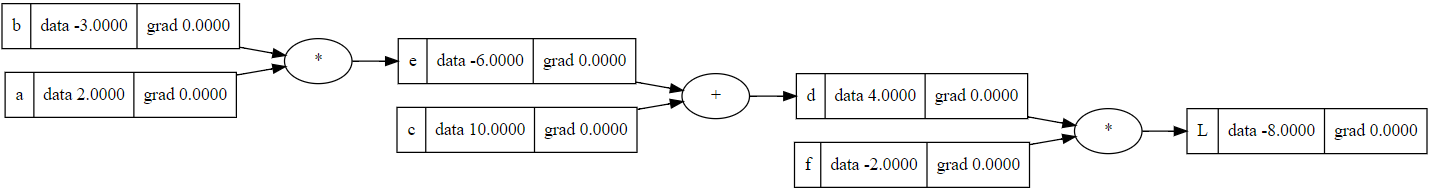

In [ ]:
# (Chain Rule)

# We know that:
# L = d * f
# d = e + c
# e = b * a (Local)

# (Local Derivative)
# If we want to calculate the derivative will be:
# de/db = ?

# We apply the calculus properties thingi:
# = (f(x + h) - f(x)) / h
# = ((b+h)*a - b*a) / h
# = (b*a + h*a - b*a) / h
# = (h*a) / h
# = a

# de/db = a
# de/db = 2.0
# This is the derivative for de/db, but we are not done yet!

In [ ]:
# Now

# Want:
# dL/db

# Know:
# dL/de and de/db

# So, we can apply the chain rule
# dL/de = (dL/de)*(de/db)
# dL/de = (-2.0)*(2.0)
# dL/de = -4.0

# So, gradient for e is -4.0

In [ ]:
b.grad = -4.0

Let's Verify

In [ ]:
# We create this function is just to not mess up the Global variables.
def lol():

  h = 0.0001

  # Without Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # With Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0 + h, label='b') # we increment h to b
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-4.000000000008441


## Calculate dL/da

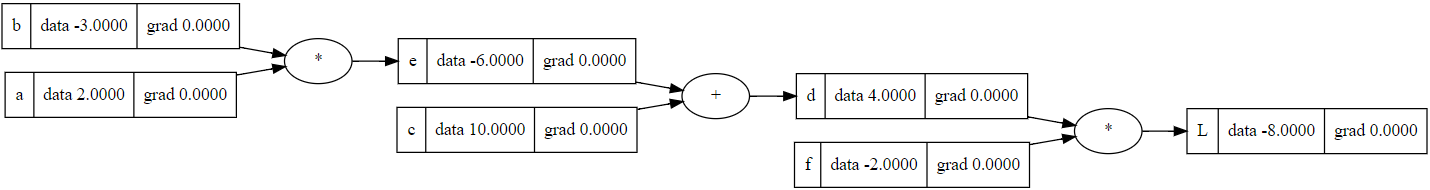

In [ ]:
# (Chain Rule)

# We know that:
# L = d * f
# d = e + c
# e = b * a (Local)

# (Local Derivative)
# If we want to calculate the derivative will be:
# de/da = ?

# We apply the calculus properties thingi:
# = (f(x + h) - f(x)) / h
# = (b*(a+h) - b*a) / h
# = (b*a + h*b - b*a) / h
# = (h*b) / h
# = b

# de/da = b
# de/da = -3.0
# This is the derivative for de/da, but we are not done yet!

In [ ]:
# Now

# Want:
# dL/da

# Know:
# dL/de and de/da

# So, we can apply the chain rule
# dL/da = (dL/de)*(de/da)
# dL/da = (-2.0)*(-3.0)
# dL/da = 6.0

# So, gradient for a is 6.0

In [ ]:
a.grad = 6.0

Let's Verify

In [ ]:
# We create this function is just to not mess up the Global variables.
def lol():

  h = 0.0001

  # Without Increment of h
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # With Increment of h
  a = Value(2.0 + h, label='a') # we increment h to a
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

6.000000000021544


## Visualize All Derivative

We have now done all of the backpropagation ! Yay!

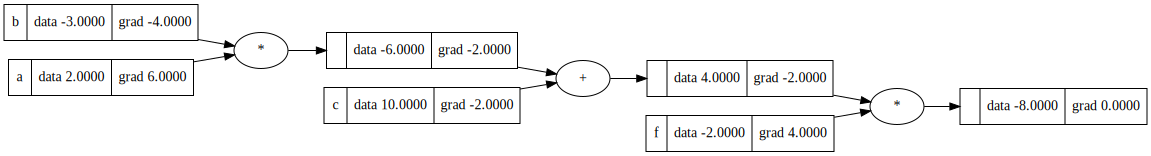

In [ ]:
draw_dot(L)

# Forward Propagation (Simple Expression)

We have now done calculating all the derivative for all variables.

We can now try to do one forward pass, which is also a single optimization step.

In [ ]:
# Our goal is to increase L
# That means we have to go in the direction of gradient.
# So, we will just increase *0.01 to each gradient.

print("Before Forward Pass, value of L: ", L.data)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print("After Forward Pass, value of L: ", L.data)

Before Forward Pass, value of L:  -8.0
After Forward Pass, value of L:  -7.286496


# Understand Neuron

w : weights

x : inputs

b : bias

w0x0 + w1x1 + w2x2 + bias

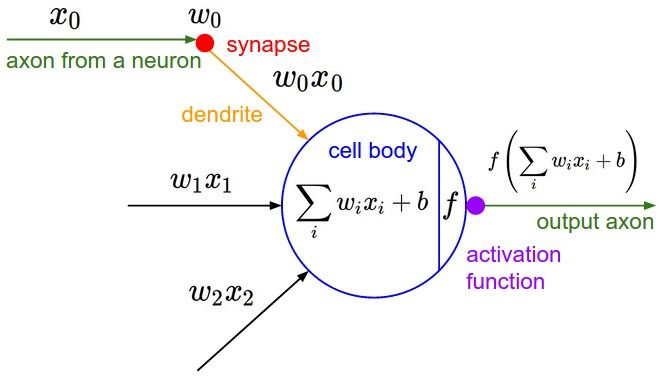

# Understand Activation function

Example: Tanh function

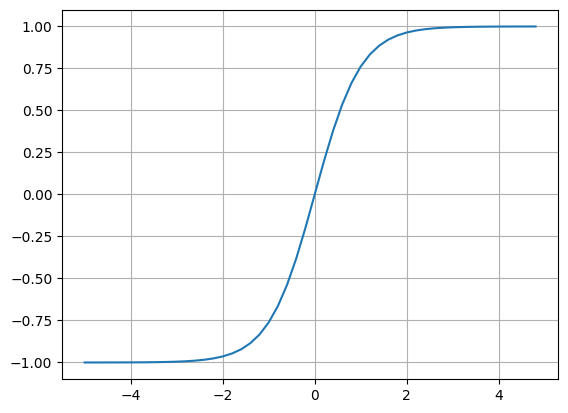

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

# Build Neuron

Let's write out the structures of neuron and activatiob function

In [22]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

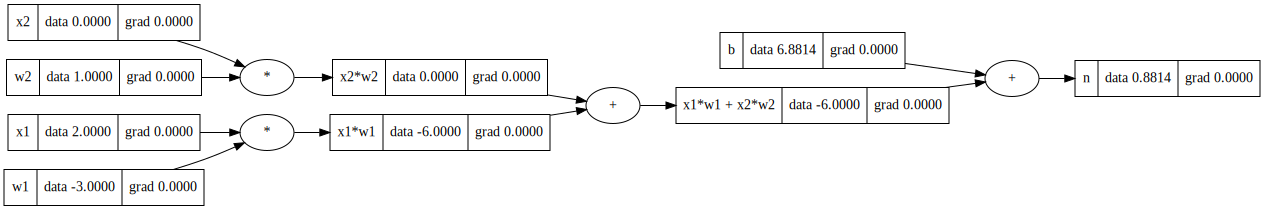

In [ ]:
draw_dot(n)

# Build Activation function Tanh

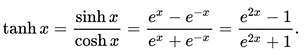

Tanh need exponential, our Value object has only sum and multiplication.

So we need to implement something to use Tanh.

The concept:

1. We can choose to add another operation exponential like + and x

2. But we can also straight build up a function for tanh

The only things that we need to know is that we can differentiate them.

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0 # gradient will initially be 0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): # function just to make python print nicer integer
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,(self, other), _op='+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,(self, other),_op='*')
    return out

  def tanh(self): # Build our tanh function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

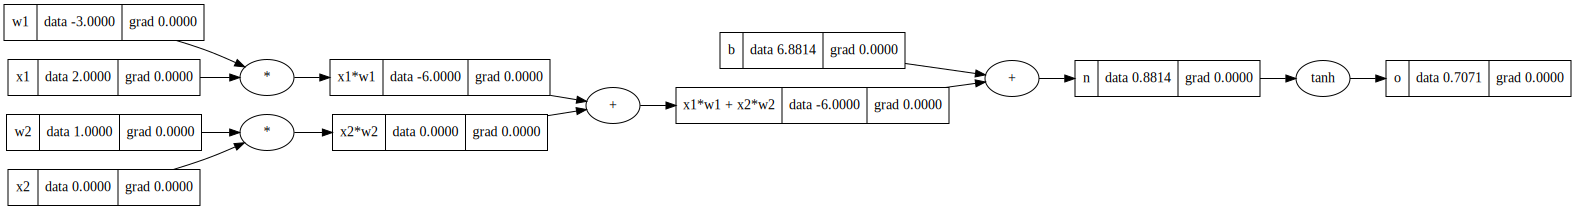

In [ ]:
draw_dot(o)

# Backpropagation (Neuron)

## Calculate do/do

In [ ]:
# Self Derivative always 1.0
o.grad = 1.0

## Calculate do/dn (Tanh)

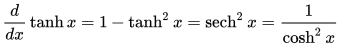

In [ ]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - (o)**2
# do/dn = 1 - 0.7071**2

print(o.data)
print(1 - o.data**2)

0.7071067811865476
0.4999999999999999


In [ ]:
n.grad = 0.5

## Calculate dn/db

Same as above when we are calculating derivative of 'Sum'

Remember the previous example, a plus is a distributor of gradient, so the gradient will just simply flow to both.

if n.grad = 0.5, then b.grad = 0.5, x1w1x2w2.grad = 0.5

In [ ]:
b.grad = 0.5

## Calculate do/x1w1x2w2

In [ ]:
x1w1x2w2.grad = 0.5

## Calculate do/x1w1

In [ ]:
x1w1.grad = 0.5

## Calculate do/x2w2

In [ ]:
x2w2.grad = 0.5

## Calculate do/w1






Based on previous experience:

We know that Multiplication will be data * previous_data.grad

In [ ]:
# (Chain Rule)

# We Know:
# x1w1 = x1 * w1

# We Want:
# x1w1/w1 = ?

# Calculate Local Derivative
# = (f(x + h) - f(x)) / h
# = ((w1+h) * x1) - x1 * w1) / h
# = x1w1 + hx1 - x1w1 / h
# = hx1 / h
# = x1

# So:
# x1w1/w1 = x1

# do/w1 = (do/x1w1)*(x1w1/w1)
# do/w1 = (0.5)*(2.0) = 1.0

In [ ]:
w1.grad = 1.0

## Calculate do/x1

In [ ]:
# (Chain Rule)

# We Know:
# x1w1 = x1 * w1

# We Want:
# x1w1/x1 = ?

# Calculate Local Derivative
# = (f(x + h) - f(x)) / h
# = ((x1+h) * w1) - x1 * w1) / h
# = x1w1 + hw1 - x1w1 / h
# = hw1 / h
# = w1

# So:
# x1w1/x1 = w1

# do/x1 = (do/x1w1)*(x1w1/x1)
# do/x1 = (0.5)*(-3.0) = -1.5

In [ ]:
x1.grad = -1.5

## Calculate do/w2

In [ ]:
w2.grad = x2.data * x2w2.grad
print(w2.grad)

0.0


## Calculate do/x2

In [ ]:
x2.grad = w2.data * x2w2.grad
print(x2.grad)

0.5


## Visualize All Derivative

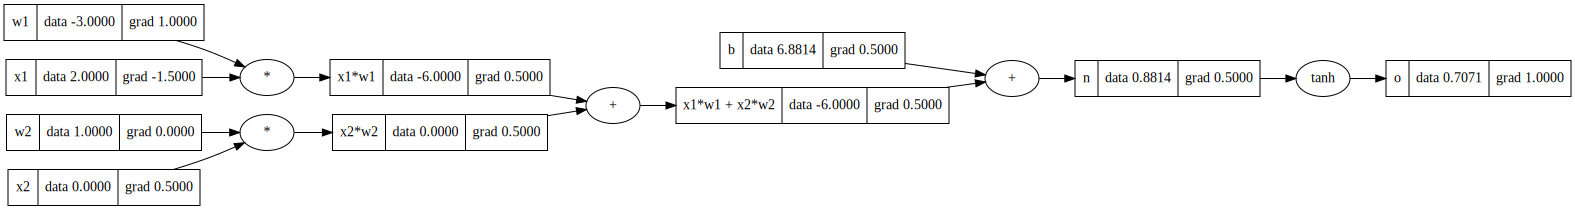

In [ ]:
draw_dot(o)

# Implement Backward function

The concept:

1. To calculate the derivative, the formula is basically:
  - (Local Derivate) * (Previous Acummulated Derivative)

2. We want to create a function, that can do such operation.

3. For example when we are computing the derivative for do/w2 in the neuron, the formula is:
  - w2.grad = x2.data * x2w2.grad
  - x2.data : is the local derivative
  - x2w2.grad : is the accumulated derivative

## Backward for +

For addition:

  - Take in self.data and other.data, return output
  - Example: a + b = c

We want it to be able to propagate the derivative to 'a' and 'b', which is the self.data and other.data

  - To calculate self.grad, which is grad of 'a'
  - The formula will be (Local Derivate) * (Accumulated Derivative)
  - Local derivative is always 1.0 (We have proven this above)
  - So it will become (1.0) * (Accumulated Derivative)
  - Acuumulated Derivative will be the grad of 'c' , which is the output
  - Final Formula: self.grad = (1.0) * (out.grad)



Simplfied formula for above explanation

- Self.grad = (Local Derivate) * (Accumulated Derivative)
- Self.grad = (1.0) * (Accumulated Derivative)
- self.grad = (1.0) * (out.grad)

Things are same for 'b', which is other.grad

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0

    self._backward = lambda: None
    # Create a _backward function, that will compute the derivate

    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,(self, other), _op='+')

    # backward for addition
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward # calling _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,(self, other),_op='*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

## Backward for *

For Multiplication
- Its basically the same, just chuck in the formula
- The local derivative for multiplication, is actually other.data (We have proven this above, check "Calculate do/w1")
- The accumulated derivative will be just out.grad

Formula for self.grad:
- self.grad = (local derivative) * (accumulated derivative)
- self.grad = (other.data) * (out.grad)

Formula for other.grad:
- other.grad = (local derivative) * (accumulated derivative)
- other.grad = (self.data) * (out.grad)

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0

    self._backward = lambda: None
    # Create a _backward function, that will compute the derivate

    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,(self, other),_op='*')

    # backward for multiplication
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward # calling _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

## Backward for Tanh

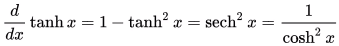

Calculate derivative for Tanh
 - o = tanh(n)
 - do/dn = 1 - tanh(n)**2

To match picture in our graph:
 - n * tanh = o
 - other * self = output

To compute self.grad, which is tanh.grad:
  - Tanh(n) function is (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
  - Tanh(n) function derivative is (1 - tanh(n)**2)
  - In our code, 't' represents Tanh(n) function

Chuck in the formula:
  - (Local derivative) * (Acummulated derivative)
  - (1 - t**2) * (out.grad)

In [ ]:
# Our Tanh function

# def tanh(self):
#   x = self.data
#   t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#   out = Value(t, (self, ), 'tanh')
#   return out

In [1]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0

    self._backward = lambda: None
    # Create a _backward function, that will compute the derivate

    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,(self, other),_op='*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    # backward for tanh
    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward

    return out

# Use Backward function

Let's try calling ._backward to propagate, keep in mind that we need to propagate in the correct order for now.

Re-assign values to Object Value Class

Re-draw our graph, with 0 grad initially

In [9]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

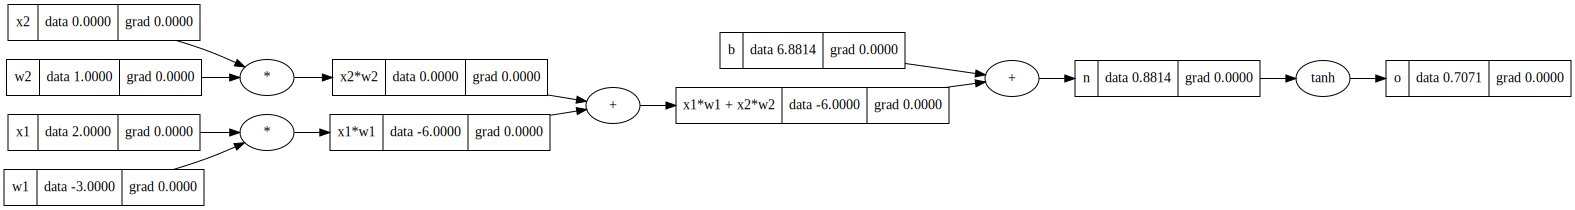

In [10]:
draw_dot(o)

Few things to note:
- Since the first derivative that we will calculate is Tanh, and Tanh ._backward will multiply out.grad, and our self.grad was initiate as 0.0, so we will need to initiate to 1.0 ourself.

- Calling ._backward for 'b' is fine although 'b' has nothing to propagate, because we initially set the function to None.

Let's just propagate one by one

In [11]:
o.grad = 1.0

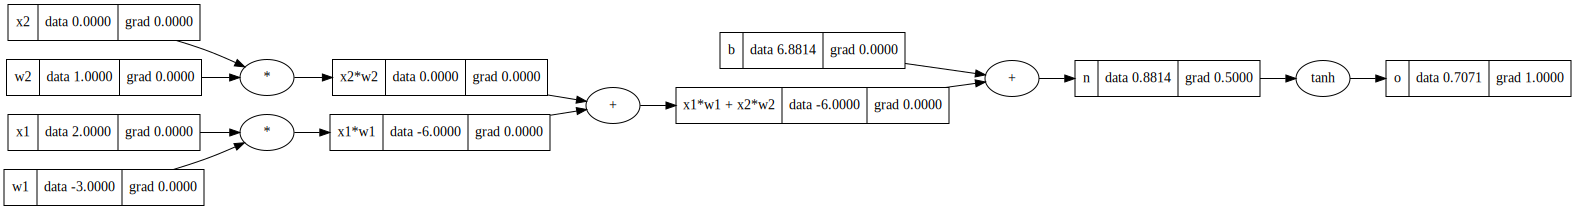

In [12]:
o._backward()
draw_dot(o)

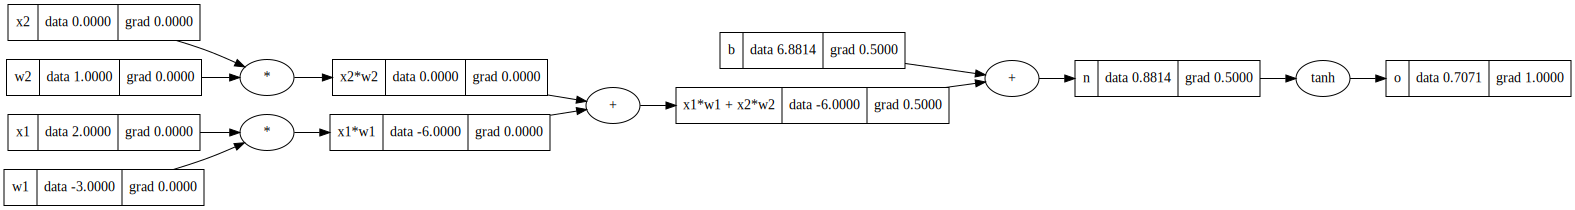

In [13]:
n._backward()
draw_dot(o)

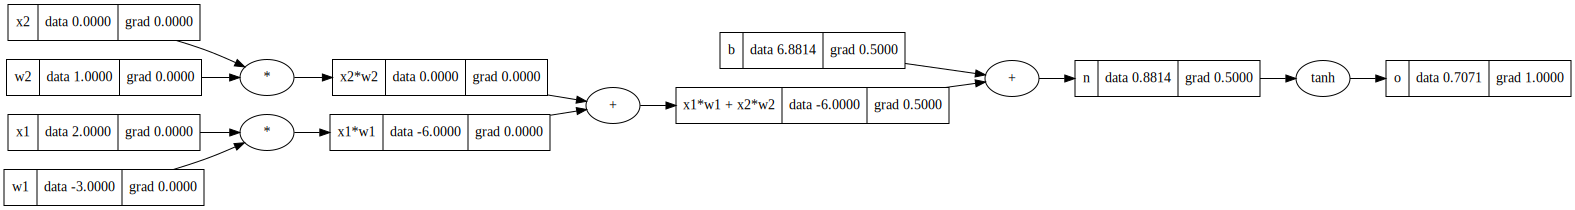

In [14]:
b._backward() # Nothing will happen
draw_dot(o)

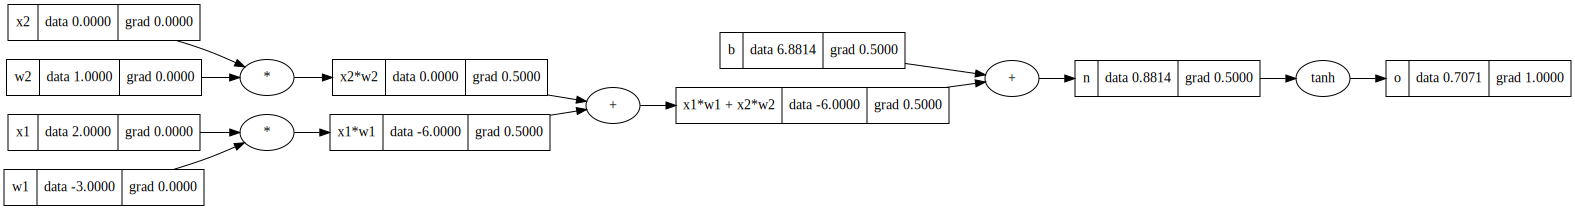

In [15]:
x1w1x2w2._backward()
draw_dot(o)

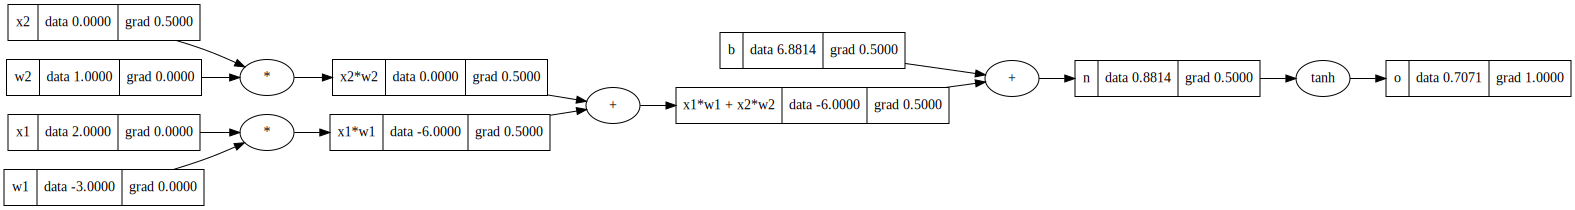

In [16]:
x2w2._backward()
draw_dot(o)

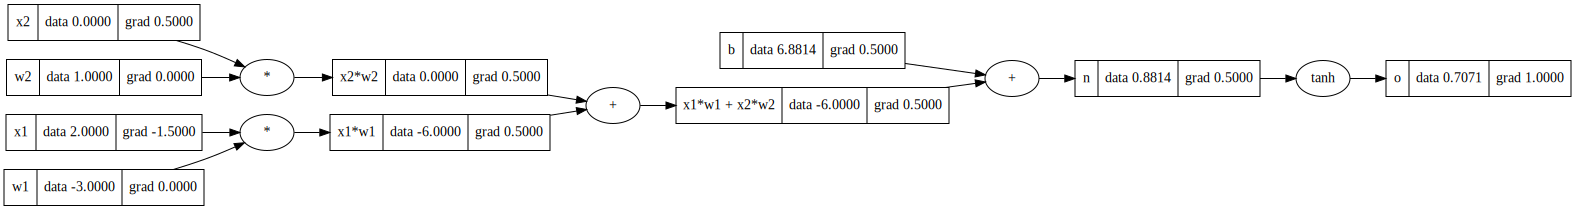

In [17]:
x1w1._backward()
draw_dot(o)

## Encapsulate Backward function

To not calculate each ._backward manually, we need to find a way to make it propagate till the last variable automatically.

The solution will be using the concept of Topological Sort.

A Topological sort will basically went through all nodes and come up with a graph in order of dependencies.

In [31]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

print(topo) # We have now all the value from the first input node to last output node.

[Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-6.0), Value(data=6.881373587019543), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


Encapsulate the function inside our Value Object

In [33]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0

    self._backward = lambda: None
    # Create a _backward function, that will compute the derivate

    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,(self, other),_op='*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    # backward for tanh
    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  # Encapsulated backward function
  def backward(self):

    # First create a topological graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # Remember to set our .grad to 1.0 (Last output grad)
    self.grad = 1.0

    # reversed the topo list, and call ._backward
    for node in reversed(topo):
      node._backward()


In [34]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

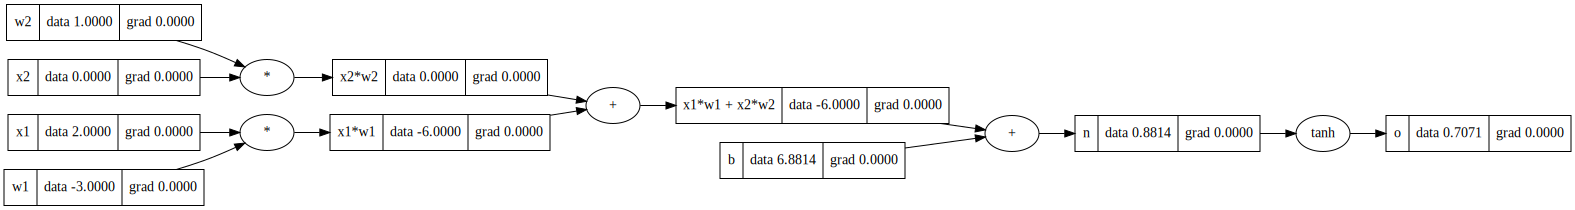

In [35]:
draw_dot(o)

In [36]:
o.backward()

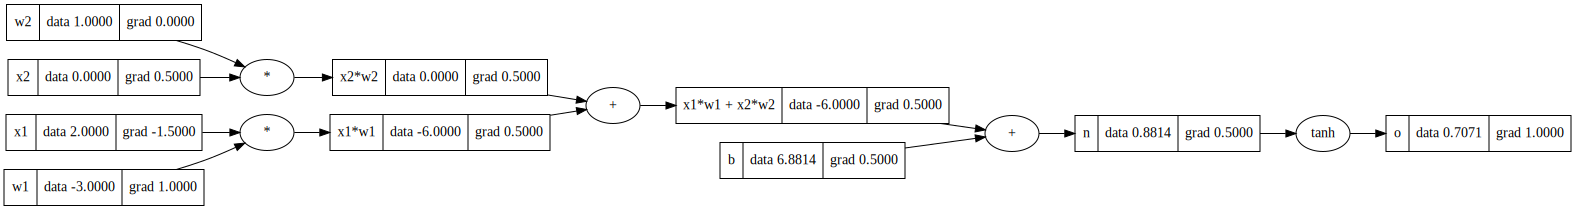

In [37]:
draw_dot(o)

# Bug !

## Problem

When we are using same variables multiple times, bug happens.

First Example

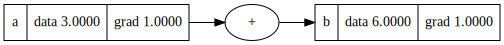

In [38]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

# Visualize is not a bug, its because there is two 'a' , it shows overlaped
# The bug is that the gradient supposely should be 2.0

Second Example

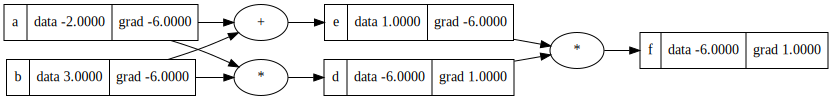

In [39]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

# Problem occured in 'a' and 'b'

## Solution

Reason:

This issue is because when calculating gradient, and if there is multiple variables that are same, the calculated gradient will overwrite the previous one.

Solution:

Instead of only calculate graident, we accumulate them.

In [41]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0

    self._backward = lambda: None
    # Create a _backward function, that will compute the derivate

    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad += 1.0 * out.grad   # Accumulate
      other.grad += 1.0 * out.grad  # Accumulate
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data,(self, other),_op='*')

    def _backward():
      self.grad += other.data * out.grad  # Accumulate
      other.grad += self.data * out.grad  # Accumulate
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    # backward for tanh
    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  # Encapsulated backward function
  def backward(self):

    # First create a topological graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # Remember to set our .grad to 1.0 (Last output grad)
    self.grad = 1.0

    # reversed the topo list, and call ._backward
    for node in reversed(topo):
      node._backward()


## Verify

First Example

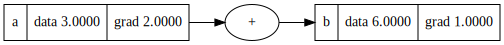

In [42]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

# Visualize is not a bug, its because there is two 'a' , it shows overlaped
# The bug is that the gradient supposely should be 2.0

Second Example

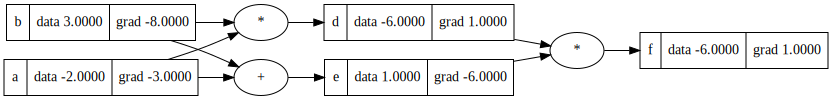

In [43]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

# Problem occured in 'a' and 'b'

# Expand - Build Tanh function

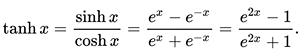

Tanh function = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)

We need:
- exponential
- power
- division
- subtraction

## Edge case problem 1

Before building operations, there is actually one thing that we cannot do now:

In [44]:
# We will get an error if we are trying to add Value Object with Integer
a = Value(2.0)
a + 1

AttributeError: ignored

Solution:
- Wrap the value

In [53]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # check and wrap
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # check and wrap
    out = Value(self.data * other.data,(self, other),_op='*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [47]:
# Verify
a = Value(2.0)
print(a+2)
print(a*3)

Value(data=4.0)
Value(data=6.0)


## Edge case problem 2

We can now do:
- (a * 2)

But (2 * a) will give error

In [54]:
a = Value(2.0)
2 * a

TypeError: ignored

Solution:
- Define something called _ _ rmul _ _
- Python will check if (2*a) is not working, python will try (a*2)

In [56]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data,(self, other),_op='*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  # Define __rmuk__
  def __rmul__(self, other): # other * self
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [58]:
# Verify
a = Value(2.0)
2 * a

Value(data=4.0)

## Build Operarion - Exp

The tricky part is how to calculate derivative for exp?
- Basically is the same, use the formula
- (Local Derivative) * (Accumulated Derivative)

Local Derivative for exp is just the data that we have calculated:
- out = Value(math.exp(x), (self, ), _op='exp')
- (out.data) * (out.grad)

Review "Backward for Tanh" if unclear

In [63]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data,(self, other), _op='*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  # Building Exp and its Backward Propagation
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), _op='exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [64]:
# Verify
a = Value(2.0)
print(a.exp())

Value(data=7.38905609893065)


## Build Operation - Division + Power

We need to understand that division can also appear in below forms:

We will choose a * (b**1), therefore we will also implement operation for power

In [ ]:
a / b
a * (1/b)
a * (b**1)

We will firist implement a define function

_ _ truediv _ _

Power function

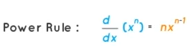

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data,(self, other), _op='*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  # Build power function
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  # Define __truediv__
  def __truediv__(self, other): # self / other
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), _op='exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [69]:
# Verify
a = Value(5.0)
b = Value(2.0)
a / b

Value(data=2.5)

## Build Operation - Subtraction + Addition

Define sub, and sub need neg.

In [102]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data,(self, other), _op='+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data,(self, other), _op='*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  # Build power function
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  # define __neg__
  def __neg__(self): # -self
    return self * -1

  # define __sub__
  def __sub__(self, other): # self - other
    return self + (-other)

  # define __rad__ for addition
  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  # Building Exp and its Backward Propagation
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), _op='exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [68]:
# Verify
a = Value(3.0)
a - 1

Value(data=2.0)

## Re-construct Graph

Breaking up Tanh function

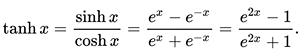

We will break it from

o = (e**2x)-1 and (e**2x)+1

to

e = (2*n).exp()

o = (e - 1) / (e + 1) <--- Passing e inside, the result is same as:

o = (e**2x)-1 and (e**2x)+1

In [71]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----------------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----------------------
o.label = 'o'

What we expect is a Longer graph, because we break tanh into pieces, at the same, we also expect the same gradient to each Value.

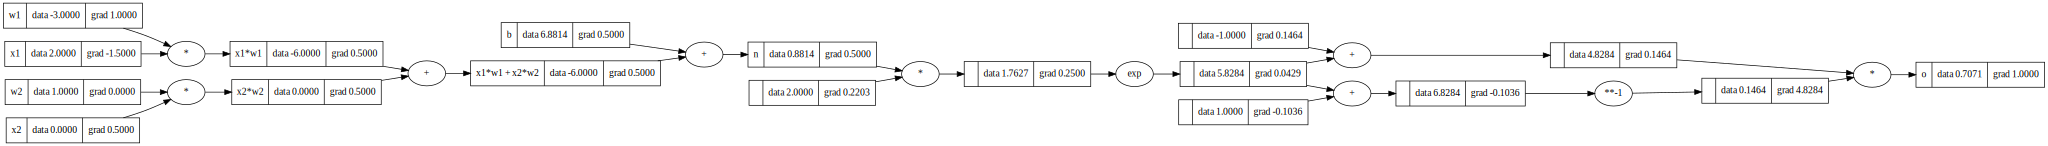

In [72]:
o.backward()
draw_dot(o)

# PyTorch Version

In [73]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Build Neuron

In [76]:
import random

In [74]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

In [77]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9327085517569805)

## Build Layer

In [78]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs


In [79]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.9574506241008167),
 Value(data=0.585845487817242),
 Value(data=-0.9317220124989809)]

## Build MLP

In [81]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [83]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data=0.36539147306831044)]

## Wrap up

In [87]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # because outs will return a list in deafult, so we take outs[0]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [88]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5955330848674836)

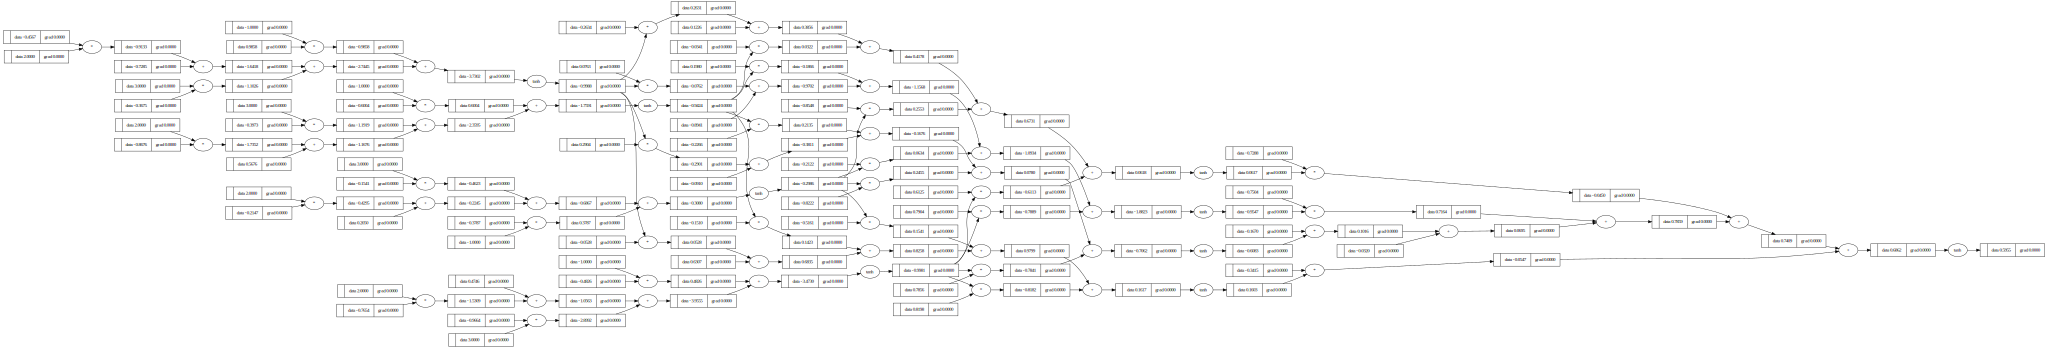

In [89]:
draw_dot(n(x))

# Testing out Network

In [90]:
# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [100]:
ypred = [n(x) for x in xs]
ypred

# This is the results we get when we feed in xs to our neuron network, garbage

[Value(data=0.5955330848674836),
 Value(data=0.3906852836260494),
 Value(data=0.544409923961272),
 Value(data=0.7177577324667054)]

Calculate loss

- Mean Squared Error

In [95]:
for y_gt, y_out in zip(ys, ypred):
  print((y_out - y_gt)**2)

Value(data=0.16359348543681423)
Value(data=1.9340055580940652)
Value(data=2.3852020132300615)
Value(data=0.07966069758233585)


Sum the loss up

In [105]:
loss = sum((y_out - y_gt)**2 for y_gt, y_out in zip(ys, ypred))
loss

Value(data=4.562461754343277)

Backpropagate

In [106]:
loss.backward()

Visualize the Graph (Expected to be big, because there is too much calculation)

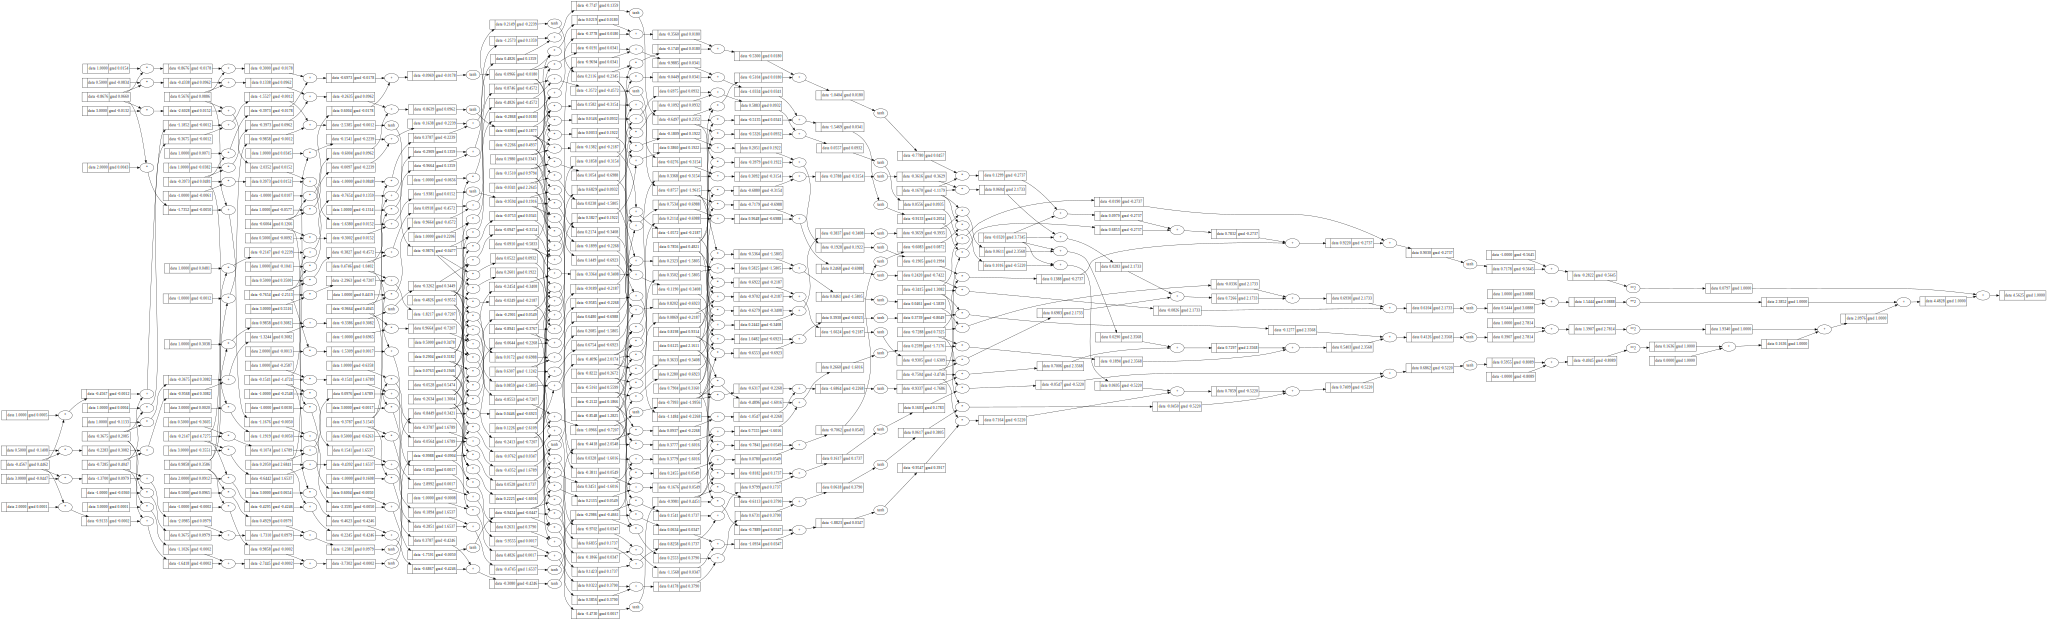

In [108]:
draw_dot(loss)

# Parameters

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]